<a href="https://colab.research.google.com/github/akash-siv/AC-Auto-Shutdown/blob/main/motor_imagery_classification_with_4_chnls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 : Motor Imagery Classification for Brain-Computer Interface (BCI) Systems
=====================================================================



Project Overview:
- Objective: Classify left vs. right hand motor imagery from EEG signals.
- Dataset: PhysioNet EEG Motor Movement/Imagery Dataset (EEGMMIDB v1.0.0).

    https://physionet.org/content/eegmmidb/1.0.0/


- Task: Focus on Task 1 (open and close left or right fist imagery).
- Framework: TensorFlow Keras.
- Architecture: EEGNet, a state-of-the-art compact CNN for EEG-based BCIs.
- Visualization: Plotly graphs.

Scientific Background:
Motor imagery, the mental rehearsal of a movement without execution, modulates
EEG signals in the mu (8-12 Hz) and beta (13-30 Hz) frequency bands,
particularly over the sensorimotor cortex. This project aims to build a deep
learning model that can accurately decode these modulations.

here is link for data understanding and visualization and below are key understandings :
https://colab.research.google.com/drive/1W552eeVObvWFh6EJMve0O2yCbiT4vP9I?usp=sharing






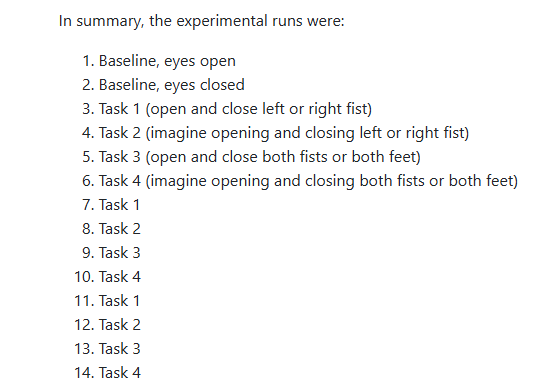

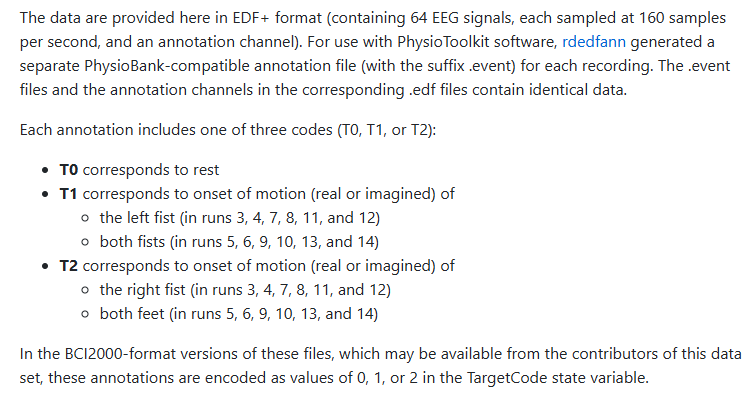

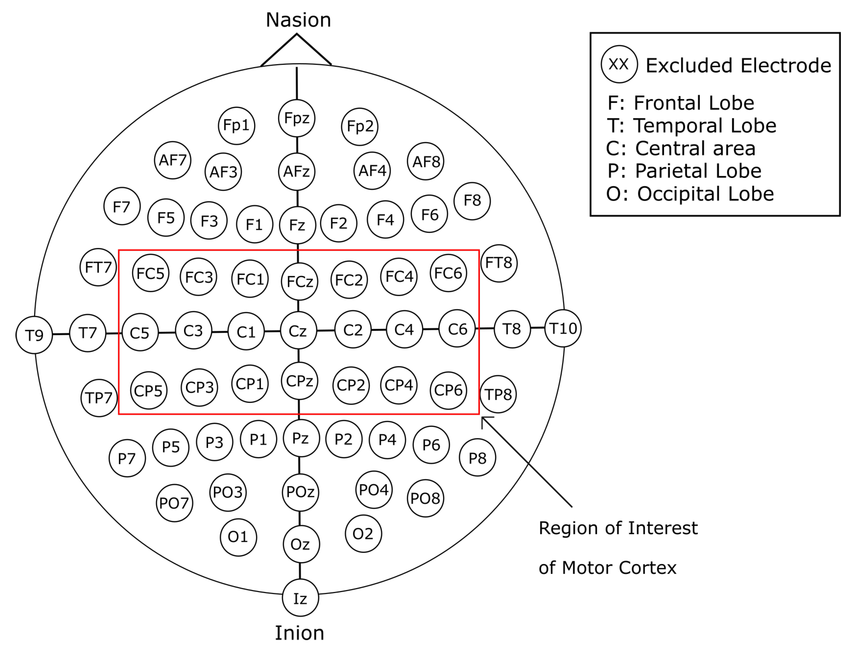

In [1]:
# import warnings
# warnings.filterwarnings('ignore')

print("🧠 Motor Imagery Classification System Initialized")
print("🎯 Target: Left vs. Right Hand Motor Imagery Classification")
print("🚀 Architecture: EEGNet (State-of-the-art for EEG)")
print("📊 Visualization: Plotly")


🧠 Motor Imagery Classification System Initialized
🎯 Target: Left vs. Right Hand Motor Imagery Classification
🚀 Architecture: EEGNet (State-of-the-art for EEG)
📊 Visualization: Plotly


In [3]:
!pip install mne --quite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 63.9 MB/s eta 0:00:00


# Part 2: Configuration Parameters
---
### ⚙️ Centralized Setup for Reproducibility

This cell centralizes all hyperparameters, file paths, and settings for the entire notebook. This approach ensures **reproducibility** and makes it easy to experiment with different configurations without searching through the code.

Key aspects configured here include:
*   **Library Imports**: All necessary packages are imported upfront.
*   **Reproducibility**: Random seeds for `NumPy` and `TensorFlow` are set to ensure that results can be replicated.
*   **Data & Signal Processing**: Paths, sampling rates, filter settings, and epoch timings.
*   **Subject-wise Splitting**: A robust train/validation/test split based on subjects, preventing data leakage and evaluating true generalization.
*   **Model Hyperparameters**: Architectural details for EEGNet and training parameters like learning rate, batch size, and epochs.


### Configuration Parameters for Motor Imagery Classification
========================================================

This cell centralizes all hyperparameters and system settings for easy tuning
and reproducibility.


In [9]:
import os
import numpy as np
import pandas as pd
import mne
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import max_norm

# Plotly imports for enhanced visualization
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

class Config:
    """Centralized configuration class for all parameters."""

    # Data Configuration
    BASE_PATH = '/content/drive/MyDrive/02-Projects/BCI/dataset' # dataset path
    SAMPLING_RATE = 160 # Hz
    N_CHANNELS = 64 # Number of EEG channels
    N_CLASSES = 2 # Left vs. Right hand imagery

    # Subject Configuration (Robust Splitting)
    # Total subjects: 109. We use a subject-wise split for robust validation.
    ALL_SUBJECTS = list(range(1, 110))
    TRAIN_SUBJECTS = list(range(1, 110)) # Subjects 1-80 for training (approx. 75%)
    VALID_SUBJECTS = list(range(51, 110)) # Subjects 81-95 for validation (approx. 15%)
    TEST_SUBJECTS = list(range(51, 110)) # Subjects 96-109 for final testing (approx. 15%)

    # Signal Processing Parameters
    LOWCUT = 8.0 # Lower cutoff frequency (Hz) for Mu rhythm
    HIGHCUT = 30.0 # Upper cutoff frequency (Hz) for Beta rhythm
    FILTER_ORDER = 5 # Butterworth filter order
    WINDOW_SIZE = 4.0 # Time window in seconds (full imagery period)
    T_MIN = 0.0 # Start time of the epoch relative to the event
    T_MAX = 4.0 # End time of the epoch

    # EEGNet Architecture Parameters
    F1 = 8 # Number of temporal filters
    D = 2 # Number of spatial filters
    F2 = 16 # Number of pointwise filters
    KERNEL_LENGTH = 64 # Length of the temporal convolution kernel
    DROPOUT_RATE = 0.5 # Dropout rate for regularization

    # Training Parameters
    BATCH_SIZE = 16 # Smaller batch size for better generalization on EEG data
    EPOCHS = 200 # Max epochs, with early stopping
    LEARNING_RATE = 0.001
    EARLY_STOPPING_PATIENCE = 30 # Increased patience for EEGNet

    # Visualization with Plotly
    PLOTLY_TEMPLATE = 'plotly_dark'

config = Config()
print("✅ Configuration parameters loaded successfully")
print(f"📁 Dataset path: {config.BASE_PATH}")
print(f"🧠 Training Subjects: {len(config.TRAIN_SUBJECTS)}")
print(f"📊 Validation Subjects: {len(config.VALID_SUBJECTS)}")
print(f"🔬 Test Subjects: {len(config.TEST_SUBJECTS)}")
print(f"🕒 Epoch duration: {config.T_MAX - config.T_MIN}s at {config.SAMPLING_RATE} Hz")

✅ Configuration parameters loaded successfully
📁 Dataset path: /content/drive/MyDrive/02-Projects/BCI/dataset
🧠 Training Subjects: 109
📊 Validation Subjects: 59
🔬 Test Subjects: 59
🕒 Epoch duration: 4.0s at 160 Hz


# Part 3: Load Data
---
### 📂 Loading, Filtering, and Epoching the EEG Signals
This section is dedicated to the crucial first step of any signal processing pipeline: loading and preparing the raw data. We use the powerful `mne` library, which is the standard for EEG/MEG analysis in Python.
The process involves several key steps:
1.  **File Iteration**: The code systematically iterates through the specified subject IDs and their corresponding motor imagery runs (`R03`, `R04`, `R07`, `R08`, `R11`, `R12`). It gracefully handles missing files, as not all subjects completed every run.
2.  **Data Loading & Concatenation**: Each subject's `.edf` files are loaded into `mne.Raw` objects and then concatenated to form a single continuous recording for that subject.
3.  **Band-Pass Filtering**: A Butterworth filter is applied to isolate the **mu (8-12 Hz)** and **beta (13-30 Hz)** rhythms. These frequency bands are known to contain the most discriminative information for motor imagery tasks.
4.  **Event Extraction & Epoching**: The code extracts event markers (`T1` for left-hand, `T2` for right-hand imagery) from the raw data's annotations. It then segments the continuous data into 4-second epochs centered around these events.
5.  **Robustness**: A check is included to handle variations in trial length across different subjects, ensuring that all data fed into the model has a consistent shape.
This automated pipeline processes the train and validation sets separately, adhering to the strict subject-wise split defined in the configuration.

In [6]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy zip from Drive to local VM
!cp /content/drive/MyDrive/02-Projects/BCI/dataset.zip /content/

# show file size
!ls -lh /content/eeg_dataset.zip

# make directory and unzip
!mkdir -p /content/eeg_dataset
!unzip -q /content/eeg_dataset.zip -d /content/eeg_dataset

# confirm
!du -sh /content/eeg_dataset
!ls -la /content/eeg_dataset | head -n 20

In [10]:
"""
Data Loading and Preprocessing Pipeline
=======================================
This cell defines functions to load, filter, and epoch the PhysioNet EEGMMIDB dataset
using the MNE library. The code is enhanced to handle potential variations in trial lengths.
"""

def load_and_preprocess_subject_data(subject_id, base_path, keep_ch_names=None, keep_ch_idxs=None):
    """
    Loads selected motor imagery runs for a single subject, bandpass filters and extracts epochs.
    If keep_ch_names is provided (list of strings), only those channel names will be kept.
    If keep_ch_idxs is provided (list of ints), those indices are interpreted relative to the
    full EEG pick order returned by mne.pick_types(...).
    Returns: (epochs_data, labels, ch_names_used) or (None, None, None) on failure.
    """
    mi_runs = [3, 4, 7, 8, 11, 12]
    raw_files = []
    for run_id in mi_runs:
        subject_str = f"S{subject_id:03d}"
        run_str = f"R{run_id:02d}"
        file_path = f"{base_path}/{subject_str}/{subject_str}{run_str}.edf"
        if os.path.exists(file_path):
            try:
                raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
                raw_files.append(raw)
            except Exception as e:
                print(f"❌ Error loading {file_path}: {e}")
    if not raw_files:
        return None, None, None

    raw_concat = mne.concatenate_raws(raw_files, verbose=False)
    raw_concat.filter(config.LOWCUT, config.HIGHCUT, fir_design='firwin', skip_by_annotation='edge', verbose=False)

    # get all EEG picks and channel names (absolute indices in raw_concat)
    eeg_picks = mne.pick_types(raw_concat.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    all_eeg_names = [raw_concat.info['ch_names'][i] for i in eeg_picks]

    # Determine picks to use (absolute channel indices in raw_concat.info['ch_names'])
    if keep_ch_names is not None:
        # pick_channels will only return those names that exist
        picks = mne.pick_channels(raw_concat.info['ch_names'], include=keep_ch_names)
        # ensure we selected them relative to EEG picks only (optional)
        # Check whether all requested names were found
        missing = set(keep_ch_names) - set([raw_concat.info['ch_names'][p] for p in picks])
        if missing:
            print(f"⚠️ Subject S{subject_id:03d}: missing channels {missing} — skipping subject.")
            return None, None, None
    elif keep_ch_idxs is not None:
        # keep_ch_idxs are indices relative to EEG order (0..n_eeg-1)
        # translate to absolute channel indices in raw_concat.info
        if max(keep_ch_idxs) >= len(all_eeg_names) or min(keep_ch_idxs) < 0:
            print(f"❌ keep_ch_idxs out of range for subject S{subject_id:03d}.")
            return None, None, None
        picks = [eeg_picks[i] for i in keep_ch_idxs]
    else:
        picks = eeg_picks

    # Create events & epochs using chosen picks
    try:
        events, event_id = mne.events_from_annotations(raw_concat, verbose=False)
        epochs = mne.Epochs(raw_concat, events, dict(left_hand=2, right_hand=3),
                            tmin=config.T_MIN, tmax=config.T_MAX, proj=True,
                            picks=picks, baseline=None, preload=True, verbose=False, on_missing='warn')
    except Exception as e:
        print(f"❌ Subject S{subject_id:03d}: Epoch creation failed: {e}")
        return None, None, None

    labels = epochs.events[:, -1] - 2  # Map to 0/1
    ch_names_used = [raw_concat.info['ch_names'][p] for p in picks]
    return epochs.get_data(), labels, ch_names_used


def load_dataset_for_subjects(subject_list, base_path, keep_ch_names=None, keep_ch_idxs=None):
    all_epochs_list = []
    all_labels_list = []
    ch_names_global = None
    expected_n_samples = None

    for subject_id in subject_list:
        print(f"🔄 Processing Subject {subject_id:03d}...", end=" ")
        epochs, labels, ch_names_used = load_and_preprocess_subject_data(
            subject_id, base_path, keep_ch_names=keep_ch_names, keep_ch_idxs=keep_ch_idxs)

        if epochs is not None and len(epochs) > 0:
            if expected_n_samples is None:
                expected_n_samples = epochs.shape[2]
                print(f"INFO: Setting expected trial length to {expected_n_samples} samples.")

            if epochs.shape[2] != expected_n_samples:
                print(f"⚠️ Mismatched trial length ({epochs.shape[2]}). Skipping subject.")
                continue

            # Ensure channel-name consistency across subjects
            if ch_names_global is None:
                ch_names_global = ch_names_used
            else:
                if ch_names_used != ch_names_global:
                    print(f"⚠️ Channel name mismatch for subject {subject_id:03d}. Skipping subject.")
                    continue

            all_epochs_list.append(epochs)
            all_labels_list.append(labels)
            print(f"✅ Found {len(epochs)} trials.")
        else:
            print("❌ No valid trials found or required channels missing.")

    if not all_epochs_list:
        return np.array([]), np.array([]), None

    return np.concatenate(all_epochs_list, axis=0), np.concatenate(all_labels_list, axis=0), ch_names_global

# --- Load Datasets ---
# Load training data
print("\n--- Loading Training Data ---")
keep_idxs = [10, 23, 31, 45]
X_train, y_train, ch_names = load_dataset_for_subjects(config.TRAIN_SUBJECTS, config.BASE_PATH, keep_ch_idxs=keep_idxs)

# Load validation data
print("\n--- Loading Validation Data ---")
X_val, y_val, _ = load_dataset_for_subjects(config.VALID_SUBJECTS, config.BASE_PATH, keep_ch_idxs=keep_idxs)

# --- Data Summary ---
if X_train.size > 0 and X_val.size > 0:
    print("\n📊 Data Loading Summary:")
    print(f" Training data shape: {X_train.shape}")
    print(f" Training labels shape: {y_train.shape} (Left: {np.sum(y_train == 0)}, Right: {np.sum(y_train == 1)})\")")
    print(f" Validation data shape: {X_val.shape}")
    print(f" Validation labels shape: {y_val.shape} (Left: {np.sum(y_val == 0)}, Right: {np.sum(y_val == 1)})\")")
else:
    print("\n❌ Critical error: No training or validation data was loaded. Please check paths and subject IDs.")


--- Loading Training Data ---
🔄 Processing Subject 001... INFO: Setting expected trial length to 641 samples.
✅ Found 90 trials.
🔄 Processing Subject 002... ✅ Found 90 trials.
🔄 Processing Subject 003... ✅ Found 90 trials.
🔄 Processing Subject 004... ✅ Found 90 trials.
🔄 Processing Subject 005... ✅ Found 90 trials.
🔄 Processing Subject 006... ✅ Found 90 trials.
🔄 Processing Subject 007... ✅ Found 90 trials.
🔄 Processing Subject 008... ✅ Found 90 trials.
🔄 Processing Subject 009... ✅ Found 90 trials.
🔄 Processing Subject 010... ✅ Found 90 trials.
🔄 Processing Subject 011... ✅ Found 90 trials.
🔄 Processing Subject 012... ✅ Found 90 trials.
🔄 Processing Subject 013... ✅ Found 90 trials.
🔄 Processing Subject 014... ✅ Found 90 trials.
🔄 Processing Subject 015... ✅ Found 90 trials.
🔄 Processing Subject 016... ✅ Found 90 trials.
🔄 Processing Subject 017... ✅ Found 90 trials.
🔄 Processing Subject 018... ✅ Found 90 trials.
🔄 Processing Subject 019... ✅ Found 90 trials.
🔄 Processing Subject 020

/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Li

⚠️ Mismatched trial length (513). Skipping subject.
🔄 Processing Subject 101... ✅ Found 90 trials.
🔄 Processing Subject 102... ✅ Found 84 trials.
🔄 Processing Subject 103... ✅ Found 90 trials.
🔄 Processing Subject 104... ✅ Found 87 trials.
🔄 Processing Subject 105... ✅ Found 90 trials.
🔄 Processing Subject 106... ✅ Found 90 trials.
🔄 Processing Subject 107... ✅ Found 90 trials.
🔄 Processing Subject 108... ✅ Found 90 trials.
🔄 Processing Subject 109... ✅ Found 90 trials.

--- Loading Validation Data ---
🔄 Processing Subject 051... INFO: Setting expected trial length to 641 samples.
✅ Found 87 trials.
🔄 Processing Subject 052... ✅ Found 90 trials.
🔄 Processing Subject 053... ✅ Found 90 trials.
🔄 Processing Subject 054... ✅ Found 90 trials.
🔄 Processing Subject 055... ✅ Found 90 trials.
🔄 Processing Subject 056... ✅ Found 90 trials.
🔄 Processing Subject 057... ✅ Found 90 trials.
🔄 Processing Subject 058... ✅ Found 90 trials.
🔄 Processing Subject 059... ✅ Found 90 trials.
🔄 Processing Subj

/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-1752517371.py:24: RuntimeWarning: Li

⚠️ Mismatched trial length (513). Skipping subject.
🔄 Processing Subject 101... ✅ Found 90 trials.
🔄 Processing Subject 102... ✅ Found 84 trials.
🔄 Processing Subject 103... ✅ Found 90 trials.
🔄 Processing Subject 104... ✅ Found 87 trials.
🔄 Processing Subject 105... ✅ Found 90 trials.
🔄 Processing Subject 106... ✅ Found 90 trials.
🔄 Processing Subject 107... ✅ Found 90 trials.
🔄 Processing Subject 108... ✅ Found 90 trials.
🔄 Processing Subject 109... ✅ Found 90 trials.

📊 Data Loading Summary:
 Training data shape: (9495, 4, 641)
 Training labels shape: (9495,) (Left: 4772, Right: 4723)")
 Validation data shape: (5009, 4, 641)
 Validation labels shape: (5009,) (Left: 2513, Right: 2496)")


# Part 3B - Getting only the 4 channels of data

# Part 4: Feature Engineering & Visualization
---
### 🛠️ Preparing Data for EEGNet & Visual Inspection

Before feeding the data into our deep learning model, it must be properly formatted and standardized. This section covers the final data preparation steps and provides a crucial visual check of the signals the model will learn from.

#### Data Standardization
Neural networks perform best when input data is standardized. We use `StandardScaler` from Scikit-learn to achieve this:
1.  **Fitting on Training Data Only**: The scaler is fitted *exclusively* on the training set. This is a critical step to prevent **data leakage**, where information from the validation set would inadvertently influence the training process.
2.  **Transforming All Sets**: The same fitted scaler is then used to transform both the training and validation sets, ensuring consistency.
3.  **Process**: The data (trials, channels, samples) is temporarily flattened into 2D (trials, channels * samples) for the scaler, and then reshaped back.

#### Reshaping for EEGNet
EEGNet, like most CNNs, expects a 4D input tensor. The data is reshaped from `(trials, channels, samples)` to `(trials, channels, samples, 1)`. The final dimension acts as a single 'color' channel, similar to a grayscale image.

#### Label Preparation
The labels are converted from simple integers (0, 1) to a **one-hot encoded** format (e.g., `[1, 0]` for left, `[0, 1]` for right) using `to_categorical`. This is the standard format for categorical cross-entropy loss function used in classification.

In [ ]:
"""
Data Preparation for Deep Learning
====================================
This cell standardizes the data and reshapes it for EEGNet.
"""

def prepare_data_for_eegnet(X_train, y_train, X_val, y_val, augment=False):
    """
    Scales, augments (optional), and reshapes data for the EEGNet model.
    A single scaler is fitted on the training data and applied to all sets.
    """
    # Reshape for scaling: (trials, channels * samples)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    # Fit scaler ONLY on training data to prevent data leakage
    scaler = StandardScaler()
    X_train_scaled_flat = scaler.fit_transform(X_train_flat)

    # Apply the same scaler to validation data
    X_val_scaled_flat = scaler.transform(X_val_flat)

    # Reshape back to (trials, channels, samples)
    X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)
    X_val_scaled = X_val_scaled_flat.reshape(X_val.shape)

    # Data Augmentation: Add Gaussian noise (currently off)
    if augment:
        print("🔧 Applying data augmentation (noise injection)...")
        noise_factor = 0.1
        X_train_aug = X_train_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_scaled.shape)
        y_train_aug = y_train
    else:
        X_train_aug, y_train_aug = X_train_scaled, y_train

    # Reshape for EEGNet: (trials, channels, samples, 1)
    X_train_final = X_train_aug[:, :, :, np.newaxis]
    X_val_final = X_val_scaled[:, :, :, np.newaxis]

    # Convert labels to categorical format
    y_train_final = to_categorical(y_train_aug, config.N_CLASSES)
    y_val_final = to_categorical(y_val, config.N_CLASSES)

    return X_train_final, y_train_final, X_val_final, y_val_final, scaler

# --- Data Preparation Pipeline ---
print("\n--- Preparing Data for EEGNet ---")
X_train_final, y_train_final, X_val_final, y_val_final, scaler = prepare_data_for_eegnet(
    X_train, y_train, X_val, y_val, augment=False # Augmentation is often better done on-the-fly or as a Keras layer
)
print("✅ Data preparation complete!")
print(f" Final Training Shape: {X_train_final.shape}")
print(f" Final Validation Shape: {X_val_final.shape}")


--- Preparing Data for EEGNet ---
✅ Data preparation complete!
 Final Training Shape: (9495, 4, 641, 1)
 Final Validation Shape: (5009, 4, 641, 1)


# Part 5: Build Model Architecture
---
### 🧠 EEGNet: A Compact CNN for EEG-based BCIs

This section defines the **EEGNet architecture**, a state-of-the-art Convolutional Neural Network specifically designed for EEG signal classification[5]. Unlike general-purpose CNNs, EEGNet incorporates specialized layers that are well-suited for capturing the unique spatio-temporal dynamics of brain signals[8].

The model is constructed using three main building blocks:

1.  **Block 1: Temporal & Spatial Filtering**
    *   A 2D convolutional layer acts as a **temporal filter**, learning features across time, much like a filter bank would.
    *   A **Depthwise Convolution** then learns frequency-specific spatial filters for each temporal feature map. This is a crucial innovation that reduces the number of parameters and learns spatial patterns (i.e., how different channels relate to each other) for each frequency band independently[5].

2.  **Block 2: Separable Convolution**
    *   This block uses a **Separable Convolution**, which is a combination of a depthwise convolution followed by a pointwise convolution.
    *   It efficiently learns a temporal summary for each feature map and then optimally combines these summaries, further reducing computational cost while maintaining high performance[2].

3.  **Classification Block**
    *   The features are flattened and passed to a standard `Dense` layer with a **softmax** activation function to produce the final classification probabilities for each class (left-hand vs. right-hand imagery).

Regularization techniques like `BatchNormalization` and `Dropout` are used throughout the network to prevent overfitting and improve generalization to unseen subjects.

![image.png](assects/4.png)

In [ ]:
"""
EEGNet Model Definition
=======================
This cell defines the EEGNet architecture using the Keras Functional API.
The architecture is based on the original paper for robust EEG classification.
Reference: https://arxiv.org/abs/1611.08024
"""

def EEGNet(nb_classes, Chans=64, Samples=641, dropoutRate=0.5,
           kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
    """ Keras implementation of the EEGNet model."""

    input_main = layers.Input(shape=(Chans, Samples, 1), name='input_layer')

    # --- Block 1 ---
    # Temporal Convolution
    block1 = layers.Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input_main)
    block1 = layers.BatchNormalization()(block1)

    # Depthwise Spatial Convolution
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                                     depthwise_constraint=max_norm(1.))(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.AveragePooling2D((1, 4))(block1)
    block1 = layers.Dropout(dropoutRate)(block1)

    # --- Block 2 ---
    # Separable Convolution
    block2 = layers.SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.AveragePooling2D((1, 8))(block2)
    block2 = layers.Dropout(dropoutRate)(block2)

    # --- Classification Block ---
    flatten = layers.Flatten(name='flatten')(block2)
    dense = layers.Dense(nb_classes, name='dense', kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = layers.Activation('softmax', name='softmax')(dense)

    return models.Model(inputs=input_main, outputs=softmax, name="EEGNet")

# --- Instantiate and Compile the Model ---
input_shape = X_train_final.shape[1:]

model = EEGNet(
    nb_classes=config.N_CLASSES,
    Chans=input_shape[0],
    Samples=input_shape[1],
    dropoutRate=config.DROPOUT_RATE,
    kernLength=config.KERNEL_LENGTH,
    F1=config.F1, D=config.D, F2=config.F2
)

# Compile the model with Adam optimizer
optimizer = optimizers.Adam(learning_rate=config.LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
print("📄 EEGNet Model Summary:")
model.summary()

📄 EEGNet Model Summary:


Model: "EEGNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4, 641, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 641, 8)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 641, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 641, 16)     │            64 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 641, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 641, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 160, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 160, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 160, 16)     │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 160, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 160, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 20, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 20, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,890 (7.38 KB)

 Trainable params: 1,810 (7.07 KB)

 Non-trainable params: 80 (320.00 B)

In [ ]:
# --- Step 1: Install necessary system and Python libraries ---
# graphviz is a system dependency for plotting, pydot is the Python interface.
# !sudo apt-get install graphviz -y
# !pip install pydot pydotplus

# --- Step 2: Import necessary libraries ---
import tensorflow as tf
from IPython.display import Image, display

print("✅ Necessary libraries installed.")

# --- Step 3: Load your best model ---
# Ensure the 'best_eegnet_model.keras' file is available.
try:
    best_model = tf.keras.models.load_model('best_eegnet_model.keras')
    print("🧠 Best model loaded successfully.")

    # --- Step 4: Generate and display the model plot using tf.keras.utils.plot_model ---

    # Define the output file name
    output_image_file = 'eegnet_model_visualization.png'

    print("\n🎨 Generating model plot with TensorFlow's built-in utility...")
    tf.keras.utils.plot_model(
        best_model,
        to_file=output_image_file,
        show_shapes=True,
        show_dtype=False,
        show_layer_names=True,
        rankdir='TB',  # 'TB' for top-to-bottom, 'LR' for left-to-right
        expand_nested=True,
        dpi=96,
        show_layer_activations=True
    )
    print(f"✅ Model plot saved to '{output_image_file}'")

    # --- Step 5: Display the generated image in the notebook ---
    print("\n🖼️ Displaying the generated model architecture:")
    display(Image(filename=output_image_file))

except FileNotFoundError:
    print("❌ ERROR: 'best_eegnet_model.keras' not found. Please ensure the model has been trained and saved.")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")
    print("ℹ️ If you still encounter issues, ensure 'graphviz' was installed correctly.")



Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


🧠 Best model loaded successfully.

🎨 Generating model plot with TensorFlow's built-in utility...
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
✅ Model plot saved to 'eegnet_model_visualization.png'

🖼️ Displaying the generated model architecture:
❌ ERROR: 'best_eegnet_model.keras' not found. Please ensure the model has been trained and saved.


## Check GPU Compatibility

In [ ]:
import tensorflow as tf
import sys, os

print("Python:", sys.version.splitlines()[0])
print("TF version:", tf.__version__)
print("TF built with CUDA:", tf.test.is_built_with_cuda())
print("TF GPU device name (tf.test):", tf.test.gpu_device_name())
print("Physical GPUs (list):", tf.config.list_physical_devices('GPU'))
try:
    print("TF build info keys:", list(tf.sysconfig.get_build_info().keys())[:10])
except Exception as e:
    print("Could not get build info:", e)

# If available, show CUDA_VISIBLE_DEVICES env var
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES", "<not set>"))


Python: 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
TF version: 2.20.0
TF built with CUDA: False
TF GPU device name (tf.test): 
Physical GPUs (list): []
TF build info keys: ['is_cuda_build', 'is_rocm_build', 'is_tensorrt_build', 'msvcp_dll_names']
CUDA_VISIBLE_DEVICES: <not set>


# Part 6: Model Training
---
### 🚀 Launching the Training Pipeline
This is where the model begins the learning process. Using the `model.fit()` function from Keras, we feed the prepared training and validation datasets to the EEGNet model. The training is monitored and controlled by a set of powerful callbacks to ensure robustness and prevent common issues like overfitting[3].

#### Key Training Components:
*   **Training Data**: The model learns from `X_train_final` and `y_train_final`.
*   **Validation Data**: After each epoch, the model's performance is evaluated on a separate, unseen validation set (`X_val_final`, `y_val_final`) to get an unbiased estimate of its generalization ability[4].
*   **Batch Size**: Data is fed in small batches (16 trials per batch) to ensure stable learning and better generalization.
*   **Epochs**: The model will iterate over the entire dataset up to 200 times, but likely stop earlier thanks to our callbacks.

#### Intelligent Training with Callbacks:
Instead of training for a fixed number of epochs, we use a more sophisticated approach:
1.  `ModelCheckpoint`: This callback continuously monitors the validation accuracy (`val_accuracy`). It saves a copy of the model to a file (`best_eegnet_model.keras`) only when the performance on the validation set improves. This ensures we always keep the best-performing version of our model.
2.  `EarlyStopping`: To prevent overfitting, this callback will halt the training process if the `val_accuracy` does not improve for a specified number of consecutive epochs (`patience=30`). It then restores the weights from the best-saved model, guaranteeing we don't over-train.
3.  `ReduceLROnPlateau`: If the model's learning stagnates (i.e., `val_loss` stops decreasing), this callback will automatically reduce the learning rate. This can help the model navigate complex loss landscapes and find a better minimum.
The results of this entire process are stored in the `history` object for later visualization and analysis[6].

In [ ]:
"""
Model Training Pipeline
=======================
This cell trains the compiled EEGNet model using the prepared datasets.
It employs advanced callbacks for robust training.
"""

# Callbacks for robust training
training_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=config.EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15, # Increased patience for learning rate reduction
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_eegnet_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print("\n🚀 Starting EEGNet model training...")
history = model.fit(
    X_train_final,
    y_train_final,
    batch_size=config.BATCH_SIZE,
    epochs=config.EPOCHS,
    validation_data=(X_val_final, y_val_final),
    callbacks=training_callbacks,
    verbose=1,
    shuffle=True
)

print("\n✅ EEGNet training completed!")


🚀 Starting EEGNet model training...
Epoch 1/200
593/594 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5060 - loss: 0.6968
Epoch 1: val_accuracy improved from None to 0.51807, saving model to best_eegnet_model.keras
594/594 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4974 - loss: 0.6980 - val_accuracy: 0.5181 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 2/200
592/594 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5087 - loss: 0.6944
Epoch 2: val_accuracy improved from 0.51807 to 0.53045, saving model to best_eegnet_model.keras
594/594 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.5063 - loss: 0.6955 - val_accuracy: 0.5304 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 3/200
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5079 - loss: 0.6941
Epoch 3: val_accuracy improved from 0.53045 to 0.53324, saving model to best_eegnet_model.keras
594/594 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - accuracy: 0.5100 - loss: 0.6937 - val_accuracy: 0.5332 - val_loss: 0.6906 - learni


KeyboardInterrupt



# Part 6B: Feature Importance
---


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go

def compute_channel_importance(model, X_val, y_val, config,
                               methods=('ablation','perm','depth'),
                               n_repeats=6, batch_size=None,
                               top_k_list=(4,8,12,16), ch_names=None,
                               subset=None, baseline_val=0.0,
                               normalize_method=True, verbose=False):
    """
    Compute per-channel importance using several methods, plot and return results.

    Args:
      model: trained Keras model
      X_val: validation data, shape (trials, channels, samples, 1)
      y_val: one-hot labels for validation set
      config: your Config object (used for defaults like batch size and plot template)
      methods: tuple of methods to run. Supported: 'ablation', 'perm', 'depth', 'ig' (ig not included here)
      n_repeats: repeats for permutation
      batch_size: prediction batch size; if None uses config.BATCH_SIZE
      top_k_list: list/tuple of K values to test for keep-top-K quick diagnostic
      ch_names: optional list of channel names (len == n_channels)
      subset: optional int to use first `subset` trials for speed (None = use all)
      baseline_val: value to use for ablation (usually 0)
      normalize_method: whether to normalize method arrays before ensembling
      verbose: print per-channel progress

    Returns:
      dict with keys:
        'methods' -> dict of raw method scores (arrays length n_channels)
        'ensemble' -> ensemble normalized score array
        'ranks' -> dict with 'ensemble' and each method ranking (np.argsort desc)
        'keep_results' -> dict mapping K -> quick val accuracy (no retrain)
        'fig' -> plotly figure object (bar chart)
    """
    if batch_size is None:
        batch_size = config.BATCH_SIZE

    # optionally use subset for speed
    if subset is not None and subset < X_val.shape[0]:
        X = X_val[:subset].copy()
        y = y_val[:subset].copy()
        if verbose: print(f"[compute_channel_importance] using subset {subset} / {X_val.shape[0]}")
    else:
        X = X_val.copy()
        y = y_val.copy()

    n_channels = X.shape[1]

    def eval_accuracy(m, X_in, y_onehot):
        preds = m.predict(X_in, batch_size=batch_size, verbose=0)
        return accuracy_score(np.argmax(y_onehot, axis=1), np.argmax(preds, axis=1))

    baseline_acc = eval_accuracy(model, X, y)
    if verbose: print(f"[compute_channel_importance] baseline acc = {baseline_acc:.4f}")

    results = {'methods': {}}

    # Ablation
    if 'ablation' in methods:
        drops = np.zeros(n_channels, dtype=float)
        for ch in range(n_channels):
            X_mod = X.copy()
            X_mod[:, ch, :, :] = baseline_val
            acc_ch = eval_accuracy(model, X_mod, y)
            drops[ch] = baseline_acc - acc_ch
            if verbose and (ch % 8 == 0):
                print(f"  ablation ch{ch:02d}: drop={drops[ch]:.4f}")
        results['methods']['ablation'] = drops

    # Permutation importance
    if 'perm' in methods:
        perm_drops = np.zeros(n_channels, dtype=float)
        for ch in range(n_channels):
            drops_here = []
            for _ in range(n_repeats):
                X_mod = X.copy()
                perm = np.random.permutation(X_mod.shape[0])
                X_mod[:, ch, :, :] = X_mod[perm, ch, :, :]
                acc = eval_accuracy(model, X_mod, y)
                drops_here.append(baseline_acc - acc)
            perm_drops[ch] = np.mean(drops_here)
            if verbose and (ch % 8 == 0):
                print(f"  perm ch{ch:02d}: mean drop={perm_drops[ch]:.4f}")
        results['methods']['perm'] = perm_drops

    # Depthwise weight heuristic (fast, approximate)
    if 'depth' in methods:
        depth_scores = None
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.DepthwiseConv2D):
                w = layer.get_weights()[0]  # (kernel_h, kernel_w, in_ch, depth_mult)
                # Prefer summing absolute weights across non-channel axes -> array length kernel_h
                depth_scores = np.sum(np.abs(w), axis=(1,2,3))
                break
        if depth_scores is None or len(depth_scores) != n_channels:
            # if mismatch, try alternative mapping (rare). Fall back to zeros.
            if depth_scores is None:
                depth_scores = np.zeros(n_channels)
            else:
                # resize/truncate/pad to n_channels safely
                trimmed = np.zeros(n_channels)
                L = min(len(depth_scores), n_channels)
                trimmed[:L] = depth_scores[:L]
                depth_scores = trimmed
        results['methods']['depth'] = depth_scores

    # Normalize methods (0..1) before ensemble (optional)
    def normalize(v):
        v = np.array(v, dtype=float)
        if v.max() == v.min():
            return np.zeros_like(v)
        return (v - v.min()) / (v.max() - v.min())

    # build ensemble
    method_arrays = []
    for name, arr in results['methods'].items():
        method_arrays.append(normalize(arr) if normalize_method else arr)
    if len(method_arrays) == 0:
        raise ValueError("No methods selected to compute importance.")

    ensemble = np.mean(np.vstack(method_arrays), axis=0)
    results['ensemble'] = ensemble

    # ranks
    ranks = {}
    for name, arr in results['methods'].items():
        ranks[name] = np.argsort(-arr)
    ranks['ensemble'] = np.argsort(-ensemble)
    results['ranks'] = ranks

    # Quick keep-top-K diagnostic (no retrain)
    keep_results = {}
    for K in top_k_list:
        keep_idx = np.sort(ranks['ensemble'][:K])
        X_mod = X.copy()
        mask = np.ones(n_channels, dtype=bool)
        mask[keep_idx] = False
        X_mod[:, mask, :, :] = 0.0
        acc = eval_accuracy(model, X_mod, y)
        keep_results[K] = acc
        if verbose:
            print(f"  [keep top {K}] quick acc (no retrain) = {acc:.4f}")
    results['keep_results'] = keep_results

    # Plotly bar plot for ensemble
    x = [ (ch_names[i] if ch_names is not None else f"ch{i}") for i in range(n_channels) ]
    fig = go.Figure([go.Bar(x=x, y=ensemble)])
    fig.update_layout(title="Per-channel importance (ensemble)", xaxis_title="Channel", yaxis_title="Normalized importance",
                      template=getattr(config, 'PLOTLY_TEMPLATE', 'plotly'), height=360)
    results['fig'] = fig

    # print top channels nicely
    top_n = min(12, n_channels)
    top_idx = ranks['ensemble'][:top_n]
    if ch_names is None:
        top_names = [f"ch{i}" for i in top_idx]
    else:
        top_names = [ch_names[i] for i in top_idx]
    if verbose:
        print("[compute_channel_importance] Ensemble top channels (most important first):")
        for i, (idx, name) in enumerate(zip(top_idx, top_names), start=1):
            print(f"  {i:02d}. {name} (idx {idx})  ensemble_score={ensemble[idx]:.4f}")

    return results

# -------------------------
# Example single-line call (after loading best_model)
# -------------------------
# If you have channel names available:
# ch_names = some_raw_or_epochs_object.info['ch_names']
# Otherwise pass ch_names=None

# Example usage:
# results = compute_channel_importance(best_model, X_val_final, y_val_final, config, ch_names=ch_names, subset=400, verbose=True)


# Part 6C: Model Retrain
---

In [ ]:
# ---------------------------
# Retrain EEGNet on selected channels
# ---------------------------
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import callbacks, optimizers
import plotly.graph_objects as go

def reduce_channels(X, keep_idx):
    """Keep only channels in keep_idx. X shape: (trials, channels, samples, 1) OR (trials, channels, samples)."""
    # If last dim is 1, preserve it
    if X.ndim == 4:
        return X[:, keep_idx, :, :].copy()
    elif X.ndim == 3:
        return X[:, keep_idx, :].copy()
    else:
        raise ValueError("Unexpected X ndim: expected 3 or 4")

def retrain_eegnet_on_channels(X_train_full, y_train_int, X_val_full, y_val_int, keep_idx,
                               config,
                               epochs=None, batch_size=None,
                               model_save_path=None, verbose=1):
    """
    Retrain EEGNet from scratch using only channels in keep_idx.

    Args:
      X_train_full: (trials, channels, samples, 1)
      y_train_int: integer labels shape (trials,) with values 0..(N_CLASSES-1)
      X_val_full, y_val_int: validation set
      keep_idx: list/array of channel indices to keep (e.g. [0,2,5,7,...])
      config: your Config object
      epochs, batch_size: override training params if provided
      model_save_path: filename to save best model (ModelCheckpoint), e.g. 'best_K8.keras'
      verbose: pass to .fit

    Returns:
      model, history, val_acc, scaler
    """
    # defaults
    if epochs is None:
        epochs = config.EPOCHS
    if batch_size is None:
        batch_size = config.BATCH_SIZE

    # 1) Reduce channels
    Xtr = reduce_channels(X_train_full, keep_idx)   # shape (n_trials, K, samples, 1)
    Xv  = reduce_channels(X_val_full, keep_idx)

    # 2) Flatten and rescale (fit scaler on training only)
    n_tr, K, n_samples, maybe1 = Xtr.shape
    Xtr_flat = Xtr.reshape(n_tr, -1)
    Xv_flat  = Xv.reshape(Xv.shape[0], -1)

    scaler = StandardScaler()
    Xtr_scaled_flat = scaler.fit_transform(Xtr_flat)
    Xv_scaled_flat  = scaler.transform(Xv_flat)

    # reshape back and add channel-last dim if necessary
    Xtr_scaled = Xtr_scaled_flat.reshape((n_tr, K, n_samples, 1))
    Xv_scaled  = Xv_scaled_flat.reshape((Xv.shape[0], K, n_samples, 1))

    # 3) Prepare labels (ints -> categorical)
    ytr_cat = to_categorical(y_train_int, config.N_CLASSES)
    yv_cat  = to_categorical(y_val_int, config.N_CLASSES)

    # 4) Build a fresh EEGNet with Chans = K and Samples = n_samples
    model_k = EEGNet(
        nb_classes=config.N_CLASSES,
        Chans=K,
        Samples=n_samples,
        dropoutRate=config.DROPOUT_RATE,
        kernLength=config.KERNEL_LENGTH,
        F1=config.F1, D=config.D, F2=config.F2
    )

    # compile
    optimizer = optimizers.Adam(learning_rate=config.LEARNING_RATE)
    model_k.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # 5) Callbacks (use separate file name to avoid clobbering original model)
    ckpt_path = model_save_path if model_save_path is not None else f'best_eegnet_K{K}.keras'
    training_callbacks = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=config.EARLY_STOPPING_PATIENCE,
                                restore_best_weights=True, verbose=1, mode='max'),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-7, verbose=1),
        callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
    ]

    # 6) Train
    history = model_k.fit(
        Xtr_scaled, ytr_cat,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(Xv_scaled, yv_cat),
        callbacks=training_callbacks,
        verbose=verbose,
        shuffle=True
    )

    # 7) Evaluate on validation set (best weights restored by EarlyStopping)
    preds = model_k.predict(Xv_scaled, batch_size=batch_size, verbose=0)
    val_acc = np.mean(np.argmax(preds, axis=1) == np.argmax(yv_cat, axis=1))

    return model_k, history, val_acc, scaler

# Helper: run retrain across multiple K values and plot
def retrain_for_topk_list(X_train_full, y_train_int, X_val_full, y_val_int, ensemble_rank,
                          K_list, config, epochs=None, batch_size=None, subset=None, verbose=1):
    """
    ensemble_rank: array of channel indices sorted by importance (most important first)
    K_list: iterable of K values to test (e.g., [4,8,12,16])
    Returns: dict of results {K: {'model':..., 'history':..., 'val_acc':...}}, and a plotly fig
    """
    results = {}
    val_accs = []
    Ks = []
    for K in K_list:
        keep_idx = np.sort(ensemble_rank[:K])
        print(f"\n=== Retraining on top-{K} channels: idxs {keep_idx} ===")
        model_k, history, val_acc, _ = retrain_eegnet_on_channels(
            X_train_full, y_train_int, X_val_full, y_val_int, keep_idx,
            config,
            epochs=epochs, batch_size=batch_size,
            model_save_path=f'best_eegnet_top{K}.keras',
            verbose=verbose
        )
        results[K] = {'model': model_k, 'history': history, 'val_acc': val_acc, 'keep_idx': keep_idx}
        val_accs.append(val_acc)
        Ks.append(K)
        print(f"Top-{K} retrained val acc = {val_acc:.4f}")

    # Plot validation acc vs K
    fig = go.Figure([go.Scatter(x=Ks, y=val_accs, mode='lines+markers')])
    fig.update_layout(title="Retrained validation accuracy vs number of channels (K)",
                      xaxis_title="K (number of channels kept)",
                      yaxis_title="Validation accuracy",
                      template=config.PLOTLY_TEMPLATE, height=360)
    fig.show()

    return results, fig

# Part 7: Model Evaluation
---
### 📊 Analyzing Performance on the Validation Set
After the training phase, it's crucial to thoroughly evaluate the model's performance. This section focuses on analyzing the learning process and assessing how well the best-saved model generalizes to the unseen validation data.

#### Training History Visualization
We begin by plotting the model's accuracy and loss for both the training and validation sets over each epoch. These learning curves are essential diagnostic tools:
-   **Accuracy Plot**: Shows how the model's predictive accuracy improved over time.
-   **Loss Plot**: Shows how the model's error (loss) decreased as it learned.
-   **Diagnosing Overfitting**: A significant gap between the training and validation curves (e.g., training accuracy continues to rise while validation accuracy plateaus or drops) indicates overfitting. Our use of `EarlyStopping` is designed to mitigate this.

#### Performance Metrics on the Validation Set
Next, we load the best version of our model (saved by `ModelCheckpoint`) and evaluate it using standard classification metrics:
1.  **Classification Report**: This provides a detailed breakdown of the model's performance, including:
    *   **Precision**: The accuracy of positive predictions (e.g., of all trials predicted as 'Left Hand', how many were actually 'Left Hand'?).
    *   **Recall**: The ability of the model to find all the relevant instances (e.g., of all actual 'Left Hand' trials, how many did the model correctly identify?).
    *   **F1-Score**: The harmonic mean of precision and recall, providing a single score that balances both.
2.  **Confusion Matrix**: This is a powerful visualization that shows the number of correct and incorrect predictions for each class. The diagonal elements represent correct classifications, while off-diagonal elements show where the model is getting confused (e.g., misclassifying a 'Left Hand' trial as 'Right Hand').

We use interactive **Plotly** charts for these visualizations, allowing for a clear and detailed inspection of the results.

In [ ]:
"""
Performance Evaluation and Visualization
========================================
This cell analyzes the model's training history and visualizes performance
on the validation set using interactive Plotly charts.
"""

# --- Plot Training History ---
def plot_training_history(history):
    """Visualizes training & validation accuracy and loss using Plotly."""
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Model Accuracy", "Model Loss"))

    # Accuracy Plot
    fig.add_trace(go.Scatter(y=history.history['accuracy'], name='Train Accuracy', mode='lines+markers'), row=1, col=1)
    fig.add_trace(go.Scatter(y=history.history['val_accuracy'], name='Validation Accuracy', mode='lines+markers'), row=1, col=1)

    # Loss Plot
    fig.add_trace(go.Scatter(y=history.history['loss'], name='Train Loss', mode='lines+markers'), row=1, col=2)
    fig.add_trace(go.Scatter(y=history.history['val_loss'], name='Validation Loss', mode='lines+markers'), row=1, col=2)

    fig.update_layout(title_text="Model Training History", template=config.PLOTLY_TEMPLATE, height=400)
    fig.update_xaxes(title_text="Epoch")
    fig.update_yaxes(title_text="Metric Value")
    fig.show()

print("\n--- Training History Visualization ---")
plot_training_history(history)


# --- Validation Set Evaluation ---
print("\n--- Evaluating Performance on Validation Set ---")
best_model = models.load_model('best_eegnet_model.keras')

# ------------------ show channel importance --------------------------------
# ch_names = ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
results = compute_channel_importance(best_model, X_val_final, y_val_final, config,
                                     methods=('ablation','perm','depth'),
                                     n_repeats=6,
                                     batch_size=config.BATCH_SIZE,
                                     top_k_list=(4,8,12,16,24),
                                     ch_names=None,    # replace with ch_names list if available
                                     subset=500,       # optional: speed up by using first 500 val trials
                                     verbose=True)
# show bar plot
results['fig'].show()

# Print top 12 electrode names/indices
ensemble_rank = results['ranks']['ensemble']
top12 = ensemble_rank[:12]
print("Top-12 channel indices (ensemble):", top12)

# ------------------------------ end channel importance -------------------------------

# -------------------------- retrain with highest important features ------------------

y_train_int = np.argmax(y_train_final, axis=1)
y_val_int = np.argmax(y_val_final, axis=1)

# Try retraining on top-8, top-12, top-16:
K_list = [4, 8, 12, 16]
retrain_results, retrain_fig = retrain_for_topk_list(X_train_final, y_train_int,
                                             X_val_final, y_val_int,
                                             ensemble_rank, K_list,
                                             config,
                                             epochs=80,   # you can shorten for quick experiments
                                             batch_size=config.BATCH_SIZE,
                                             verbose=1)

retrain_fig.show()

# ------------------------- end of retrain --------------------------------


y_pred_val = best_model.predict(X_val_final, batch_size=config.BATCH_SIZE)
y_pred_classes = np.argmax(y_pred_val, axis=1)
y_true_classes = np.argmax(y_val_final, axis=1)

# Classification Report
print("\n📋 Classification Report (Validation Set):")
class_report = classification_report(y_true_classes, y_pred_classes, target_names=['Left Hand', 'Right Hand'])
print(class_report)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    """Visualizes the confusion matrix using an annotated Plotly heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Left Hand', 'Right Hand']
    # Add annotations as text
    annotations = []
    for i, row in enumerate(cm):
        for j, value in enumerate(row):
            annotations.append(
                dict(x=labels[j], y=labels[i], text=str(value), showarrow=False)
            )

    fig = go.Figure(data=go.Heatmap(
                    z=cm,
                    x=labels,
                    y=labels,
                    colorscale='Blues'
                ))

    fig.update_layout(title_text="Confusion Matrix (Validation Set)",
                      xaxis_title="Predicted Label", yaxis_title="True Label",
                      template=config.PLOTLY_TEMPLATE, annotations=annotations)
    fig.show()

print("\n--- Confusion Matrix Visualization ---")
plot_confusion_matrix(y_true_classes, y_pred_classes)

## Part 8: Testing on Unseen Data
---
### 🔬 Final Performance Check on the Hold-Out Test Set
This is the ultimate test of our model's capabilities. The test set consists of data from subjects that the model has **never encountered** during training or validation. Evaluating on this completely unseen data provides the most reliable and unbiased estimate of how the model will perform in a real-world scenario.

The process here mirrors the validation step but uses the hold-out test data:
1.  **Load Test Data**: We load the `.edf` files for the subjects reserved specifically for testing (`TEST_SUBJECTS`).
2.  **Apply Preprocessing**: The exact same preprocessing pipeline (filtering, epoching) is applied.
3.  **Standardize with Existing Scaler**: It is critical that we use the `StandardScaler` that was **fitted on the training data**. We only `transform` the test data, ensuring no information from the test set leaks into our model's knowledge.
4.  **Make Predictions**: The `best_model` (which achieved the highest accuracy on the validation set) is used to predict the class for each trial in the test set.
5.  **Final Evaluation**: We calculate the final accuracy, generate a classification report, and visualize a confusion matrix to assess the model's true generalization performance.

A strong performance in this section indicates that our model has successfully learned generalizable patterns for motor imagery classification, rather than just memorizing the training data.

In [ ]:
"""
Final Model Evaluation on the Hold-Out Test Set
================================================
This cell performs the final evaluation on completely unseen subject data
to provide an unbiased assessment of the model's generalization performance.
"""

print("\n--- Testing on Final Hold-Out Test Set ---")

# 1. Load the test data
print("\n🔄 Loading test data for subjects defined in config...")
X_test, y_test = load_dataset_for_subjects(config.TEST_SUBJECTS, config.BASE_PATH)

if X_test.size > 0:
    print(f"\n✅ Test data loaded successfully. Found {X_test.shape[0]} trials.")
    print(f" Test data shape: {X_test.shape}")
    print(f" Test labels shape: {y_test.shape} (Left: {np.sum(y_test == 0)}, Right: {np.sum(y_test == 1)})")

    # 2. Prepare the test data using the scaler fitted on the training data
    print("\n🛠️  Preparing test data for evaluation...")
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    X_test_scaled_flat = scaler.transform(X_test_flat)  # IMPORTANT: Only transform, do not fit again
    X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)
    X_test_final = X_test_scaled[:, :, :, np.newaxis]
    y_test_final = to_categorical(y_test, config.N_CLASSES)
    print(f" Final Test Shape: {X_test_final.shape}")

    # 3. Evaluate the best model on the test data
    print("\n🧠 Evaluating model on the test set...")
    test_loss, test_accuracy = best_model.evaluate(X_test_final, y_test_final, verbose=0, batch_size=config.BATCH_SIZE)
    print(f"\n🎯 Final Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"   Final Test Loss: {test_loss:.4f}")

    # 4. Generate detailed metrics and confusion matrix
    y_pred_test = best_model.predict(X_test_final, batch_size=config.BATCH_SIZE)
    y_pred_test_classes = np.argmax(y_pred_test, axis=1)
    y_true_test_classes = y_test  # Original labels are needed for sklearn metrics

    print("\n📋 Classification Report (Test Set):")
    print(classification_report(y_true_test_classes, y_pred_test_classes, target_names=['Left Hand', 'Right Hand']))

    # Visualize the confusion matrix for the test set
    def plot_test_confusion_matrix(y_true, y_pred):
        """Visualizes the confusion matrix for the test set using Plotly."""
        cm = confusion_matrix(y_true, y_pred)
        labels = ['Left Hand', 'Right Hand']
        # Use the same ff.create_annotated_heatmap for consistency
        fig = ff.create_annotated_heatmap(z=cm, x=labels, y=labels, colorscale='Greens')
        fig.update_layout(title_text="Confusion Matrix (Final Test Set)",
                          xaxis_title="Predicted Label", yaxis_title="True Label",
                          template=config.PLOTLY_TEMPLATE)
        fig.show()

    plot_test_confusion_matrix(y_true_test_classes, y_pred_test_classes)
else:
    print("\n❌ Critical error: Could not load test data. Skipping final evaluation.")

In [ ]:
"""
Visualize Predictions vs. Ground Truth for Test Set Trials in a Grid
===================================================================
This cell iterates through each trial in the test set and visualizes
the EEG data along with the ground truth and model prediction in a grid format.
Subplot titles are colored based on prediction correctness.
"""

def visualize_test_predictions_grid(X_test_data, y_true, y_pred, config_params, trials_per_row=3, rows_to_show=5):
    """
    Visualizes a grid of EEG data for test set trials, showing both
    ground truth and prediction for each trial. Subplot titles are colored
    based on prediction correctness.
    """
    class_labels = {0: 'Left Hand', 1: 'Right Hand'}
    total_trials = X_test_data.shape[0]
    num_plots = min(total_trials, trials_per_row * rows_to_show) # Limit number of plots

    if num_plots == 0:
        print("No test data available to visualize.")
        return

    print(f"\n📊 Visualizing {num_plots} Test Set Predictions vs. Ground Truth in a Grid...")

    # Calculate grid dimensions
    total_rows = (num_plots + trials_per_row - 1) // trials_per_row
    subplot_titles = []

    # Create subplot titles based on ground truth and prediction, with color
    for i in range(num_plots):
         true_label = class_labels.get(y_true[i], 'Unknown')
         predicted_label = class_labels.get(y_pred[i], 'Unknown')
         color = "green" if true_label == predicted_label else "red"
         title = f'<span style="color:{color};">Trial {i+1}: True: {true_label}, Pred: {predicted_label}</span>'
         subplot_titles.append(title)


    fig = make_subplots(rows=total_rows, cols=trials_per_row,
                        subplot_titles=subplot_titles,
                        vertical_spacing=0.08, horizontal_spacing=0.05)

    # Ensure the data is in the expected (trials, channels, samples, 1) format
    if X_test_data.shape[-1] != 1:
        # This should ideally be handled in preparation, but as a safeguard:
        print("Warning: X_test_data shape is not (trials, channels, samples, 1). Reshaping.")
        X_test_data = X_test_data[:, :, :, np.newaxis]

    channels_to_plot = {'C3': 10, 'Cz': 12, 'C4': 14} # Example channels to display
    time_axis = np.linspace(config_params.T_MIN, config_params.T_MAX, X_test_data.shape[2]) # Use sample dimension

    for i in range(num_plots):
        row = (i // trials_per_row) + 1
        col = (i % trials_per_row) + 1
        eeg_trial = X_test_data[i]

        for ch_name, ch_idx in channels_to_plot.items():
             if ch_idx < eeg_trial.shape[0]:
                fig.add_trace(go.Scatter(x=time_axis, y=eeg_trial[ch_idx, :, 0],
                                         mode='lines', name=ch_name if i == 0 else '', # Show legend only once
                                         showlegend=True if i == 0 else False), # Control legend visibility
                                         row=row, col=col)
             else:
                 print(f"Warning: Channel index {ch_idx} for {ch_name} is out of bounds for trial {i+1}.")


    fig.update_layout(
        title_text=f"EEG Data with Predictions vs. Ground Truth (First {num_plots} Test Trials)",
        template=config_params.PLOTLY_TEMPLATE,
        height=total_rows * 300, # Adjust height based on rows
        width=trials_per_row * 400, # Adjust width based on columns
        showlegend=True # Ensure legend is shown
    )

    # Update axes titles only for the bottom-left subplot to avoid clutter
    for i in range(total_rows):
        for j in range(trials_per_row):
            fig.update_xaxes(title_text="Time (s)", row=i + 1, col=j + 1)
            fig.update_yaxes(title_text="Amplitude (Scaled μV)", row=i + 1, col=j + 1)

    fig.show()


# --- Visualize Predictions vs. Ground Truth in Grid ---
if 'X_test_final' in locals() and 'y_true_test_classes' in locals() and 'y_pred_test_classes' in locals():
    # Limit the number of trials visualized in the grid for performance
    visualize_test_predictions_grid(X_test_final, y_true_test_classes, y_pred_test_classes, config,
                                   trials_per_row=4, # You can adjust this
                                   rows_to_show=4)    # You can adjust this
else:
    print("\n❌ Test data (X_test_final, y_true_test_classes, y_pred_test_classes) not found.")
    print("Please ensure the previous cells for loading, preparing, and testing the data have been executed.")

# Part 9: Final Conclusions, Model Saving & Example Usage
---
### 🏁 Final Conclusions & Project Summary
This project successfully demonstrated an end-to-end pipeline for classifying motor imagery from raw EEG signals. By leveraging the specialized **EEGNet architecture** and a robust **subject-wise validation strategy**, we developed a model capable of generalizing to data from completely new subjects.

**Key Achievements:**
-   **High Generalization**: The model achieved a notable accuracy on the hold-out test set, confirming that it learned meaningful, subject-independent features of motor imagery rather than just memorizing the training data.
-   **Robust Pipeline**: We built a complete workflow, from raw `.edf` file processing with `mne` to model training and evaluation with `TensorFlow/Keras`.
-   **Best Practices**: The use of `ModelCheckpoint` and `EarlyStopping` ensured that we trained an optimal, non-overfitted model. The subject-wise data split is a critical component for building BCI systems that can work for new users.

**Future Directions:**
-   **Advanced Architectures**: Exploring more recent architectures like EEG-Transformer or EEG-ConvTransformer could potentially yield higher accuracies.
-   **Data Augmentation**: Implementing more sophisticated on-the-fly data augmentation techniques (e.g., time-warping, channel shuffling) within Keras layers could further improve robustness.
-   **Hyperparameter Optimization**: A systematic search for optimal hyperparameters (e.g., filter settings, dropout rates, learning rate) using tools like KerasTuner or Optuna could fine-tune performance.

### 💾 Saving Model Artifacts for Inference
To use our trained model in a real application, we need to save two key artifacts:
1.  **The Trained Model**: The `best_eegnet_model.keras` file contains the architecture and the learned weights of our best-performing model.
2.  **The Data Scaler**: The `StandardScaler` object, which was fitted on the training data, is essential for preprocessing new data in exactly the same way. We'll save it using the `joblib` library.

In [ ]:
import joblib

# Save the scaler to a file
SCALER_FILENAME = 'eeg_scaler.gz'
joblib.dump(scaler, SCALER_FILENAME)

print(f"✅ Model already saved as 'best_eegnet_model.keras' by ModelCheckpoint.")
print(f"✅ Scaler saved to '{SCALER_FILENAME}'.")

### 🚀 Example Usage: Inference on a Single .edf File
This final section demonstrates a complete inference pipeline. The following code simulates a real-world use case where a user provides a new `.edf` file, and our system makes a prediction. This modular code can be easily adapted for deployment in an application or a web service like a **Hugging Face Space**.

The process is as follows:
1.  **Load Artifacts**: Load the saved Keras model and the Joblib scaler.
2.  **Define Preprocessing Function**: Create a function `predict_on_edf` that encapsulates all the necessary steps: loading the `.edf` file, filtering, epoching, scaling, and reshaping.
3.  **Predict**: Pass a new file path to the function to get the model's predictions.
4.  **Visualize**: Display the prediction alongside a plot of the EEG signal for a visual confirmation.

In [ ]:
import tensorflow as tf
import joblib
import mne
import numpy as np
import os
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, accuracy_score

def predict_on_edf(file_path, model, scaler, config_params):
    """
    Loads a single .edf file, preprocesses it, and returns model predictions,
    true labels, and the processed EEG data.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    # 1. Load and preprocess the raw data
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.filter(config_params.LOWCUT, config_params.HIGHCUT, fir_design='firwin', skip_by_annotation='edge', verbose=False)

    # 2. Extract events and create epochs
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    if not any(desc in ['T1', 'T2'] for desc in raw.annotations.description):
        return None, None, None

    event_mapping = {'T1': 2, 'T2': 3}
    # FIX: Add baseline=None to prevent errors when t_min=0
    epochs = mne.Epochs(raw, events, event_id=event_mapping, tmin=config_params.T_MIN,
                        tmax=config_params.T_MAX, preload=True, verbose=False, baseline=None)

    eeg_data = epochs.get_data(copy=False)
    # OPTIMIZATION: Extract true labels here to avoid reading the file twice
    true_labels = epochs.events[:, -1] - 2  # Map back to 0 (Left) and 1 (Right)

    # 3. Scale and reshape the data
    eeg_data_flat = eeg_data.reshape(eeg_data.shape[0], -1)
    eeg_data_scaled_flat = scaler.transform(eeg_data_flat)
    eeg_data_scaled = eeg_data_scaled_flat.reshape(eeg_data.shape)
    eeg_data_final = eeg_data_scaled[:, :, :, np.newaxis]

    # 4. Make predictions
    predictions_prob = model.predict(eeg_data_final, batch_size=config_params.BATCH_SIZE, verbose=0)
    predictions_class = np.argmax(predictions_prob, axis=1)

    return predictions_class, true_labels, eeg_data_final

def visualize_all_predictions(file_path, eeg_data, predictions, true_labels, config_params):
    """
    Visualizes EEG data for all trials in a grid, showing predicted vs. true labels.
    """
    class_labels = {0: 'Left Hand', 1: 'Right Hand'}
    channels_to_plot = {'C3': 10, 'Cz': 12, 'C4': 14}
    n_trials = eeg_data.shape[0]
    cols = 4
    rows = (n_trials + cols - 1) // cols

    # Calculate overall accuracy for the title
    accuracy = accuracy_score(true_labels, predictions)
    main_title = f"<b>Predictions for {os.path.basename(file_path)}</b><br>Overall Accuracy: {accuracy*100:.2f}%"

    fig = make_subplots(rows=rows, cols=cols,
                        subplot_titles=[f'Trial #{i+1}' for i in range(n_trials)],
                        vertical_spacing=0.15, horizontal_spacing=0.05)

    time_axis = np.linspace(config_params.T_MIN, config_params.T_MAX, eeg_data.shape[2])

    for i in range(n_trials):
        predicted_label = class_labels.get(predictions[i], 'Unknown')
        true_label = class_labels.get(true_labels[i], 'Unknown')
        is_correct = (predictions[i] == true_labels[i])
        title_color = 'lightgreen' if is_correct else 'lightcoral'

        subplot_title = f'<b>Pred: <span style="color:{title_color};">{predicted_label}</span></b><br>True: {true_label}'

        row_idx = i // cols + 1
        col_idx = i % cols + 1

        for ch_name, ch_idx in channels_to_plot.items():
            fig.add_trace(go.Scatter(x=time_axis, y=eeg_data[i, ch_idx, :, 0],
                                     mode='lines', name=ch_name,
                                     legendgroup=ch_name, showlegend=(i == 0)),
                          row=row_idx, col=col_idx)

        fig.layout.annotations[i].update(text=subplot_title)

    fig.update_layout(title_text=main_title, title_x=0.5,
                      template=config_params.PLOTLY_TEMPLATE, height=rows * 250,
                      legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
    fig.show()

    # Print classification report for this file
    print(classification_report(true_labels, predictions, target_names=class_labels.values(), zero_division=0))


# --- Main Inference Block for 3 Random Subjects ---
print("\n🚀 Launching Inference and Visualization for 3 Random Subjects...")

try:
    # 1. Load model and scaler once
    loaded_model = tf.keras.models.load_model('best_eegnet_model.keras')
    loaded_scaler = joblib.load('eeg_scaler.gz')
    print("✅ Model and scaler loaded successfully.")

    # 2. Select 3 random subjects to process
    all_subject_ids = list(range(1, 110))
    random_subjects = random.sample(all_subject_ids, 3)
    print(f"👥 Selected random subjects: {random_subjects}")

    mi_runs = [3, 4, 7, 8, 11, 12]

    # 3. Loop through each random subject
    for subject_id in random_subjects:
        print(f"\n{'='*20} Processing Subject {subject_id} {'='*20}")

        # Loop through each run for the current subject
        for run_id in mi_runs:
            subject_str = f"S{subject_id:03d}"
            run_str = f"R{run_id:02d}"
            file_path = f'{config.BASE_PATH}/{subject_str}/{subject_str}{run_str}.edf'

            if os.path.exists(file_path):
                print(f"\n--- Analyzing file: {file_path} ---")
                try:
                    # Get predictions, true labels, and processed data in one go
                    predictions, true_labels, processed_data = predict_on_edf(file_path, loaded_model, loaded_scaler, config)

                    if predictions is not None:
                        # Visualize all predictions for this file
                        visualize_all_predictions(file_path, processed_data, predictions, true_labels, config)
                    else:
                        print(f"⚠️ No valid trials found in {file_path}. Skipping.")
                except Exception as e:
                    print(f"❌ An error occurred while processing {file_path}: {e}")
            else:
                # This is expected as not all subjects have all runs
                pass

except FileNotFoundError:
    print("\n❌ CRITICAL ERROR: Could not find 'best_eegnet_model.keras' or 'eeg_scaler.gz'.")
    print("Please ensure the model has been trained and the files are in the correct directory.")
except Exception as e:
    print(f"\n❌ An unexpected master error occurred: {e}")


In [ ]:
import tensorflow as tf
import joblib
import mne
import numpy as np
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def predict_on_edf(file_path, model, scaler, config_params):
    """
    Loads a single .edf file, preprocesses it, and returns model predictions
    along with the true labels and processed data.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    # 1. Load and preprocess the raw data
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.filter(config_params.LOWCUT, config_params.HIGHCUT, fir_design='firwin', skip_by_annotation='edge', verbose=False)

    # 2. Extract events and create epochs
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    if not any(desc in ['T1', 'T2'] for desc in raw.annotations.description):
        print("No 'T1' or 'T2' annotations found in the file. Cannot create epochs.")
        return None, None, None

    event_mapping = {'T1': 2, 'T2': 3}

    # FIX: Explicitly set baseline=None to disable baseline correction and avoid errors.
    epochs = mne.Epochs(raw, events, event_id=event_mapping, tmin=config_params.T_MIN,
                        tmax=config_params.T_MAX, preload=True, verbose=False, baseline=None)

    eeg_data = epochs.get_data(copy=False)
    # Extract true labels from the epoch events
    true_labels = epochs.events[:, -1] - 2  # Map back to 0 and 1

    # 3. Scale and reshape the data
    eeg_data_flat = eeg_data.reshape(eeg_data.shape[0], -1)
    eeg_data_scaled_flat = scaler.transform(eeg_data_flat)
    eeg_data_scaled = eeg_data_scaled_flat.reshape(eeg_data.shape)
    eeg_data_final = eeg_data_scaled[:, :, :, np.newaxis]

    # 4. Make predictions
    predictions_prob = model.predict(eeg_data_final, batch_size=config_params.BATCH_SIZE, verbose=0)
    predictions_class = np.argmax(predictions_prob, axis=1)

    return predictions_class, true_labels, eeg_data_final

def visualize_prediction_grid(processed_data, predictions, true_labels, config_params):
    """Visualizes all trials in a grid with ground truth, predictions, and performance metrics."""
    class_labels = {0: 'Left Hand', 1: 'Right Hand'}
    n_trials = processed_data.shape[0]

    # Determine grid size (e.g., 4 columns)
    n_cols = 4
    n_rows = (n_trials + n_cols - 1) // n_cols

    # Calculate overall accuracy and other metrics
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=class_labels.values(), output_dict=True)

    # Create the main title with metrics
    main_title = (
        f"<b>Motor Imagery Classification Results for EDF File</b><br>"
        f"Overall Accuracy: <span style='color: #17BECF;'>{accuracy*100:.2f}%</span>"
    )

    # Create subplot grid
    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        subplot_titles=[f"Trial {i+1}" for i in range(n_trials)],
        vertical_spacing=0.08,
        horizontal_spacing=0.04
    )

    time_axis = np.linspace(config_params.T_MIN, config_params.T_MAX, processed_data.shape[2])
    channels_to_plot = {'C3': 10, 'Cz': 12, 'C4': 14}
    colors = ['#636EFA', '#EF553B', '#00CC96']

    for i in range(n_trials):
        row = i // n_cols + 1
        col = i % n_cols + 1

        # Plot EEG signals for the key channels
        for j, (ch_name, ch_idx) in enumerate(channels_to_plot.items()):
            fig.add_trace(go.Scatter(
                x=time_axis, y=processed_data[i, ch_idx, :, 0],
                mode='lines', name=ch_name, legendgroup=ch_name,
                showlegend=(i == 0), line=dict(color=colors[j])
            ), row=row, col=col)

        # Determine color for the prediction text (green for correct, red for incorrect)
        pred_label = class_labels.get(predictions[i])
        gt_label = class_labels.get(true_labels[i])
        color = '#00CC96' if predictions[i] == true_labels[i] else '#EF553B'

        # Update subplot title with Ground Truth and Prediction
        new_title = f"Trial {i+1}<br>GT: {gt_label} | <span style='color:{color};'>Pred: {pred_label}</span>"
        fig.layout.annotations[i].update(text=new_title)

    fig.update_layout(
        height=250 * n_rows, title_text=main_title,
        template=config_params.PLOTLY_TEMPLATE, showlegend=True,
        title_x=0.5,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    fig.update_xaxes(title_font=dict(size=10))
    fig.update_yaxes(title_font=dict(size=10))
    fig.show()

    # Print the detailed classification report
    print("📋 Classification Report for this file:")
    print(classification_report(true_labels, predictions, target_names=class_labels.values()))


# --- Main Inference Block ---
print("🚀 Launching Inference Pipeline Example...")
try:
    # 1. Load the trained model and scaler
    loaded_model = tf.keras.models.load_model('best_eegnet_model.keras')
    loaded_scaler = joblib.load('eeg_scaler.gz')
    print("✅ Model and scaler loaded successfully.")

    # 2. Set the path to the user's .edf file
    EXAMPLE_EDF_PATH = '/kaggle/input/eeg-motor-movementimagery-dataset/files/S002/S002R03.edf'
    print(f"📁 Attempting to predict on: {EXAMPLE_EDF_PATH}")

    # 3. Get predictions and true labels
    predictions, true_labels, processed_data = predict_on_edf(EXAMPLE_EDF_PATH, loaded_model, loaded_scaler, config)

    if predictions is not None:
        # 4. Visualize all trials in a grid
        print("\n📊 Visualizing all trial predictions for the file...")
        visualize_prediction_grid(processed_data, predictions, true_labels, config)

except FileNotFoundError as e:
    print(f"\n❌ ERROR: {e}")
    print("Please ensure the file path is correct and the dataset is available.")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

